In [1]:
cd ../src

/workspace/Script/NLP/PII/src


In [2]:
import os
import gc
import sys
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
from metrics_loss.metrics import compute_metrics

# Params

In [4]:
data_path = Path(r"/database/kaggle/PII/data")
CHECKPOINT_PATH = Path(r"/database/kaggle/PII/checkpoint")
os.listdir(data_path)

['train.json',
 'mpware_mixtral8x7b_v1.1-no-i-username.json',
 'pii_dataset_fixed.csv',
 'mixtral-8x7b-v1.json',
 '.~lock.lecture2.pptx#',
 'Fake_data_1850_218.json',
 'test.json',
 'archive.zip',
 'archive',
 'pii-masking-200k.csv',
 'sample_submission.csv',
 'mpware_mixtral8x7b_v1.1.json']

In [5]:
FOLD_NAME = "fold_msk_5_seed_42"
model_name = "longformer-large-4096"
folder = CHECKPOINT_PATH/Path(fr'{FOLD_NAME}/{model_name}/')

In [6]:
LABEL2TYPE = ('NAME_STUDENT','EMAIL','USERNAME','ID_NUM', 'PHONE_NUM','URL_PERSONAL','STREET_ADDRESS','O')
TYPE2LABEL = {t: l for l, t in enumerate(LABEL2TYPE)}
ID_TYPE = {"0-0":0,"0-1":1,
           "1-0":2,"1-1":3,
           "2-0":4,"2-1":5,
           "3-0":6,"3-1":7,
           "4-0":8,"4-1":9,
           "5-0":10,"5-1":11,
           "6-0":12,"6-1":13
          }

ID_NAME = {"0-0":"B-NAME_STUDENT","0-1":"I-NAME_STUDENT",
           "1-0":"B-EMAIL","1-1":"I-EMAIL",
           "2-0":"B-USERNAME","2-1":"I-USERNAME",
           "3-0":"B-ID_NUM","3-1":"I-ID_NUM",
           "4-0":"B-PHONE_NUM","4-1":"I-PHONE_NUM",
           "5-0":"B-URL_PERSONAL","5-1":"I-URL_PERSONAL",
           "6-0":"B-STREET_ADDRESS","6-1":"I-STREET_ADDRESS",
           "7-0":"O","7-1":"O"
          }


In [7]:
def read_data_stack(folder_path,df=None,name=None):
    dfx = pd.read_parquet(folder_path/'stack_oof.gzip')
    dfx['label'] = dfx['label'].fillna(7).astype(np.int32)
    dfx[['document','token','label_pred']] = dfx[['document','token','label_pred']].astype(np.int32)
#     df = df[~((df.label_pred==df.label) & (df.label==7))]
    cols = [x for x in dfx.columns if x not in ['doc_size','row_id']]
    if df is not None:
        print('add')
        df[[x+name for x in LABEL2TYPE]] = dfx[list(LABEL2TYPE)].values
        cols = [x for x in df.columns if x not in ['doc_size','row_id']]
        return df[cols]
    else:
        dfx['I'] = dfx['I'].fillna(0)
        return dfx[cols]

In [8]:
df = read_data_stack(folder/"2024-04-11--lf_nb_ad0_rep0_v1")
df.shape

(4992533, 16)

In [9]:
df = read_data_stack(folder/"2024-04-06--dv3l_cp_nbrod_add00_rep_00_v1",df=df,name='_dv3l')
df.shape

add


(4992533, 24)

In [10]:
df = read_data_stack(folder/"2024-04-03--dv3l_cp_nbrod_add05_rep_05_v1",df=df,name='_dv3l_rep05')
df.shape

add


(4992533, 32)

In [11]:
df.head()

,document,token,tokens,label_pred,score,NAME_STUDENT,EMAIL,USERNAME,ID_NUM,PHONE_NUM,URL_PERSONAL,STREET_ADDRESS,O,label,I,fold_msk_5_seed_42,NAME_STUDENT_dv3l,EMAIL_dv3l,USERNAME_dv3l,ID_NUM_dv3l,PHONE_NUM_dv3l,URL_PERSONAL_dv3l,STREET_ADDRESS_dv3l,O_dv3l,NAME_STUDENT_dv3l_rep05,EMAIL_dv3l_rep05,USERNAME_dv3l_rep05,ID_NUM_dv3l_rep05,PHONE_NUM_dv3l_rep05,URL_PERSONAL_dv3l_rep05,STREET_ADDRESS_dv3l_rep05,O_dv3l_rep05
0,16,0,Reporting,7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999
1,16,1,process,7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,16,2,|,7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,16,3,by,7,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.9997
4,16,4,Gilberto,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [12]:
def add_features(df_vsub1):
    for lab in tqdm(LABEL2TYPE):
        df_vsub1[lab+"_mean"] = df_vsub1[[lab,lab+'_dv3l',lab+'_dv3l_rep05']].mean(axis=1)
        df_vsub1[lab+"_min"] = df_vsub1[[lab,lab+'_dv3l',lab+'_dv3l_rep05']].min(axis=1)
        df_vsub1[lab+"_max"] = df_vsub1[[lab,lab+'_dv3l',lab+'_dv3l_rep05']].max(axis=1)
        
        for lag in [1,-1,2,-2]:
            df_vsub1[lab+f"_mean_{lag}"] = df_vsub1.groupby('document')[lab+"_mean"].transform(lambda x:x.shift(lag))
            df_vsub1[lab+f"_min_{lag}"] = df_vsub1.groupby('document')[lab+"_min"].transform(lambda x:x.shift(lag))
            df_vsub1[lab+f"_max_{lag}"] = df_vsub1.groupby('document')[lab+"_max"].transform(lambda x:x.shift(lag))
    
    df['token_size'] = df['tokens'].str.len()
    df['token_as_int'] = ((df['tokens'].str.contains('\d', regex=True))*1).astype(np.int16)
    return df

In [13]:
df = add_features(df)
df.shape

  0%|          | 0/8 [00:00<?, ?it/s]

(4992533, 154)

In [14]:
df.head()

,document,token,tokens,label_pred,score,NAME_STUDENT,EMAIL,USERNAME,ID_NUM,PHONE_NUM,URL_PERSONAL,STREET_ADDRESS,O,label,I,fold_msk_5_seed_42,NAME_STUDENT_dv3l,EMAIL_dv3l,USERNAME_dv3l,ID_NUM_dv3l,PHONE_NUM_dv3l,URL_PERSONAL_dv3l,STREET_ADDRESS_dv3l,O_dv3l,NAME_STUDENT_dv3l_rep05,EMAIL_dv3l_rep05,USERNAME_dv3l_rep05,ID_NUM_dv3l_rep05,PHONE_NUM_dv3l_rep05,URL_PERSONAL_dv3l_rep05,STREET_ADDRESS_dv3l_rep05,O_dv3l_rep05,NAME_STUDENT_mean,NAME_STUDENT_min,NAME_STUDENT_max,NAME_STUDENT_mean_1,NAME_STUDENT_min_1,NAME_STUDENT_max_1,NAME_STUDENT_mean_-1,NAME_STUDENT_min_-1,NAME_STUDENT_max_-1,NAME_STUDENT_mean_2,NAME_STUDENT_min_2,NAME_STUDENT_max_2,NAME_STUDENT_mean_-2,NAME_STUDENT_min_-2,NAME_STUDENT_max_-2,EMAIL_mean,EMAIL_min,EMAIL_max,EMAIL_mean_1,EMAIL_min_1,EMAIL_max_1,EMAIL_mean_-1,EMAIL_min_-1,EMAIL_max_-1,EMAIL_mean_2,EMAIL_min_2,EMAIL_max_2,EMAIL_mean_-2,EMAIL_min_-2,EMAIL_max_-2,USERNAME_mean,USERNAME_min,USERNAME_max,USERNAME_mean_1,USERNAME_min_1,USERNAME_max_1,USERNAME_mean_-1,USERNAME_min_-1,USERNAME_max_-1,USERNAME_mean_2,USERNAME_min_2,USERNAME_max_2,USERNAME_mean_-2,USERNAME_min_-2,USERNAME_max_-2,ID_NUM_mean,ID_NUM_min,ID_NUM_max,ID_NUM_mean_1,ID_NUM_min_1,ID_NUM_max_1,ID_NUM_mean_-1,ID_NUM_min_-1,ID_NUM_max_-1,ID_NUM_mean_2,ID_NUM_min_2,ID_NUM_max_2,ID_NUM_mean_-2,ID_NUM_min_-2,ID_NUM_max_-2,PHONE_NUM_mean,PHONE_NUM_min,PHONE_NUM_max,PHONE_NUM_mean_1,PHONE_NUM_min_1,PHONE_NUM_max_1,PHONE_NUM_mean_-1,PHONE_NUM_min_-1,PHONE_NUM_max_-1,PHONE_NUM_mean_2,PHONE_NUM_min_2,PHONE_NUM_max_2,PHONE_NUM_mean_-2,PHONE_NUM_min_-2,PHONE_NUM_max_-2,URL_PERSONAL_mean,URL_PERSONAL_min,URL_PERSONAL_max,URL_PERSONAL_mean_1,URL_PERSONAL_min_1,URL_PERSONAL_max_1,URL_PERSONAL_mean_-1,URL_PERSONAL_min_-1,URL_PERSONAL_max_-1,URL_PERSONAL_mean_2,URL_PERSONAL_min_2,URL_PERSONAL_max_2,URL_PERSONAL_mean_-2,URL_PERSONAL_min_-2,URL_PERSONAL_max_-2,STREET_ADDRESS_mean,STREET_ADDRESS_min,STREET_ADDRESS_max,STREET_ADDRESS_mean_1,STREET_ADDRESS_min_1,STREET_ADDRESS_max_1,STREET_ADDRESS_mean_-1,STREET_ADDRESS_min_-1,STREET_ADDRESS_max_-1,STREET_ADDRESS_mean_2,STREET_ADDRESS_min_2,STREET_ADDRESS_max_2,STREET_ADDRESS_mean_-2,STREET_ADDRESS_min_-2,STREET_ADDRESS_max_-2,O_mean,O_min,O_max,O_mean_1,O_min_1,O_max_1,O_mean_-1,O_min_-1,O_max_-1,O_mean_2,O_min_2,O_max_2,O_mean_-2,O_min_-2,O_max_-2,token_size,token_as_int
0,16,0,Reporting,7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,1.0000,0.9999,1.0000,NaN,NaN,NaN,1.0000,1.0000,1.0000,NaN,NaN,NaN,1.0000,1.0000,1.0000,9,0
1,16,1,process,7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0

# Modeling

In [15]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import operator
import typing as tp
lgb.__version__

'3.3.5'

In [16]:
import pickle

#==============================================================================================
def save_pickle(name,var):
    # print(f"Saving {name} ....")
    with open(name+'.pkl','wb') as fout:
        pickle.dump(var,fout)
    fout.close()

In [17]:
#==============================================================================================
def lgbm_features_importance(clf,features,n=15,size=(15,12)):
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()

    fold_importance_df=fold_importance_df.sort_values("importance",ascending=False).iloc[:n,:]
    plt.figure(figsize=size)
    sns.barplot(x="importance", y="Feature", data=fold_importance_df) 
    plt.title('Features importance ')
    plt.tight_layout()
    plt.show()
    
    
#==============================================================================================
def fit_lgbm(param,
             dtrain,
             dval,
             features,
             categoricals,
             target,
             fold = 0,
             es = 100,
             vb_eval = 10,
             n_iter = 5_000_000,
             min_lr = 1e-3,
            ):
    print(param)
    # Penalization Beta
#     beta = 2.5
#     LgbmLoss = CustomLGBM(beta)

    trn_data=lgb.Dataset(dtrain[features], label=dtrain[target],categorical_feature=categoricals)
    val_data=lgb.Dataset(dval[features], label=dval[target],categorical_feature=categoricals)
    
    clf=lgb.train(params = param, train_set=trn_data,
                        num_boost_round=n_iter, 
                        valid_sets = [trn_data,val_data],
                        verbose_eval=vb_eval,
#                         fobj=LgbmLoss.return_grad_and_hess,
#                         feval=LgbmLoss.return_loss,
                        early_stopping_rounds = es,
                        learning_rates = lambda iter: max(param["learning_rate"] * (0.99 ** iter),min_lr),
                 )
    
    oof = clf.predict(dval[features],num_iteration=clf.best_iteration)
    
#     s = {}
#     for i,tg in enumerate(ALL_TARGETS):
#         s[tg] = smape(dval[tg].values, oof[:,i])
#     print(s)
    
#     s = {}
#     for i,tg in enumerate(ALL_TARGETS):
#         s[tg] = mae(dval[tg].values, oof[:,i])
#     print(s)
    
    lgbm_features_importance(clf,features,n=30,size=(15,12))
    
    dico = {
        "clf":clf,
#         "mse":loss,
#         "correlation":corr,
        "fold":fold
       }    
    
    save_pickle(str(args.checkpoints_path/f'fold_{fold}'),dico)
    return dico

#     save_pickle(str(name),clf)
    
    
#==============================================================================================        
def kfold(args,df):
       
    k = len(set(df[args.kfold_name].unique().tolist()) -set([-1]))

    print(f"----------- {args.kfold_name} ---------")
    for i in range(k):
        if i in args.selected_folds:
            print(f"\n-------------   Fold {i+1} / {k}  -------------\n")
            
            val_ind = df[args.kfold_name]==i
            train_df = df[~(df[args.kfold_name].isin([i,-1]))].reset_index(drop=True)
            valid_df = df[val_ind].reset_index(drop=True)
            
            trn_len = len(train_df)
            val_len = len(valid_df)
            
            print(f"Train ({trn_len}) Validation ({val_len})")
            oof = fit_lgbm(args.param,
                        train_df,
                        valid_df,
                        features = args.features,
                        categoricals = args.categoricals,
                        target = args.target,
                        fold = i,
                        es = args.es,
                        vb_eval = args.vb_eval,
                        n_iter = args.n_iter,
                        min_lr = args.min_lr)
    return oof

In [18]:
df.columns.tolist()

['document',
 'token',
 'tokens',
 'label_pred',
 'score',
 'NAME_STUDENT',
 'EMAIL',
 'USERNAME',
 'ID_NUM',
 'PHONE_NUM',
 'URL_PERSONAL',
 'STREET_ADDRESS',
 'O',
 'label',
 'I',
 'fold_msk_5_seed_42',
 'NAME_STUDENT_dv3l',
 'EMAIL_dv3l',
 'USERNAME_dv3l',
 'ID_NUM_dv3l',
 'PHONE_NUM_dv3l',
 'URL_PERSONAL_dv3l',
 'STREET_ADDRESS_dv3l',
 'O_dv3l',
 'NAME_STUDENT_dv3l_rep05',
 'EMAIL_dv3l_rep05',
 'USERNAME_dv3l_rep05',
 'ID_NUM_dv3l_rep05',
 'PHONE_NUM_dv3l_rep05',
 'URL_PERSONAL_dv3l_rep05',
 'STREET_ADDRESS_dv3l_rep05',
 'O_dv3l_rep05',
 'NAME_STUDENT_mean',
 'NAME_STUDENT_min',
 'NAME_STUDENT_max',
 'NAME_STUDENT_mean_1',
 'NAME_STUDENT_min_1',
 'NAME_STUDENT_max_1',
 'NAME_STUDENT_mean_-1',
 'NAME_STUDENT_min_-1',
 'NAME_STUDENT_max_-1',
 'NAME_STUDENT_mean_2',
 'NAME_STUDENT_min_2',
 'NAME_STUDENT_max_2',
 'NAME_STUDENT_mean_-2',
 'NAME_STUDENT_min_-2',
 'NAME_STUDENT_max_-2',
 'EMAIL_mean',
 'EMAIL_min',
 'EMAIL_max',
 'EMAIL_mean_1',
 'EMAIL_min_1',
 'EMAIL_max_1',
 'EMAIL_mea

In [37]:
features = [
     'NAME_STUDENT_mean',
     'NAME_STUDENT_min',
     'NAME_STUDENT_max',
     'NAME_STUDENT_mean_1',
     'NAME_STUDENT_min_1',
     'NAME_STUDENT_max_1',
     'NAME_STUDENT_mean_-1',
     'NAME_STUDENT_min_-1',
     'NAME_STUDENT_max_-1',
     'NAME_STUDENT_mean_2',
     'NAME_STUDENT_min_2',
     'NAME_STUDENT_max_2',
     'NAME_STUDENT_mean_-2',
     'NAME_STUDENT_min_-2',
     'NAME_STUDENT_max_-2',
     'EMAIL_mean',
     'EMAIL_min',
     'EMAIL_max',
     'EMAIL_mean_1',
     'EMAIL_min_1',
     'EMAIL_max_1',
     'EMAIL_mean_-1',
     'EMAIL_min_-1',
     'EMAIL_max_-1',
     'EMAIL_mean_2',
     'EMAIL_min_2',
     'EMAIL_max_2',
     'EMAIL_mean_-2',
     'EMAIL_min_-2',
     'EMAIL_max_-2',
     'USERNAME_mean',
     'USERNAME_min',
     'USERNAME_max',
     'USERNAME_mean_1',
     'USERNAME_min_1',
     'USERNAME_max_1',
     'USERNAME_mean_-1',
     'USERNAME_min_-1',
     'USERNAME_max_-1',
     'USERNAME_mean_2',
     'USERNAME_min_2',
     'USERNAME_max_2',
     'USERNAME_mean_-2',
     'USERNAME_min_-2',
     'USERNAME_max_-2',
     'ID_NUM_mean',
     'ID_NUM_min',
     'ID_NUM_max',
     'ID_NUM_mean_1',
     'ID_NUM_min_1',
     'ID_NUM_max_1',
     'ID_NUM_mean_-1',
     'ID_NUM_min_-1',
     'ID_NUM_max_-1',
     'ID_NUM_mean_2',
     'ID_NUM_min_2',
     'ID_NUM_max_2',
     'ID_NUM_mean_-2',
     'ID_NUM_min_-2',
     'ID_NUM_max_-2',
     'PHONE_NUM_mean',
     'PHONE_NUM_min',
     'PHONE_NUM_max',
     'PHONE_NUM_mean_1',
     'PHONE_NUM_min_1',
     'PHONE_NUM_max_1',
     'PHONE_NUM_mean_-1',
     'PHONE_NUM_min_-1',
     'PHONE_NUM_max_-1',
     'PHONE_NUM_mean_2',
     'PHONE_NUM_min_2',
     'PHONE_NUM_max_2',
     'PHONE_NUM_mean_-2',
     'PHONE_NUM_min_-2',
     'PHONE_NUM_max_-2',
     'URL_PERSONAL_mean',
     'URL_PERSONAL_min',
     'URL_PERSONAL_max',
     'URL_PERSONAL_mean_1',
     'URL_PERSONAL_min_1',
     'URL_PERSONAL_max_1',
     'URL_PERSONAL_mean_-1',
     'URL_PERSONAL_min_-1',
     'URL_PERSONAL_max_-1',
     'URL_PERSONAL_mean_2',
     'URL_PERSONAL_min_2',
     'URL_PERSONAL_max_2',
     'URL_PERSONAL_mean_-2',
     'URL_PERSONAL_min_-2',
     'URL_PERSONAL_max_-2',
     'STREET_ADDRESS_mean',
     'STREET_ADDRESS_min',
     'STREET_ADDRESS_max',
     'STREET_ADDRESS_mean_1',
     'STREET_ADDRESS_min_1',
     'STREET_ADDRESS_max_1',
     'STREET_ADDRESS_mean_-1',
     'STREET_ADDRESS_min_-1',
     'STREET_ADDRESS_max_-1',
     'STREET_ADDRESS_mean_2',
     'STREET_ADDRESS_min_2',
     'STREET_ADDRESS_max_2',
     'STREET_ADDRESS_mean_-2',
     'STREET_ADDRESS_min_-2',
     'STREET_ADDRESS_max_-2',
     'O_mean',
     'O_min',
     'O_max',
     'O_mean_1',
     'O_min_1',
     'O_max_1',
     'O_mean_-1',
     'O_min_-1',
     'O_max_-1',
     'O_mean_2',
     'O_min_2',
     'O_max_2',
     'O_mean_-2',
     'O_min_-2',
     'O_max_-2',
    'token_as_int','token_size','label_pred']
categoricals = ['token_as_int','label_pred']
len(features)

123

In [38]:
df['label'].value_counts()

7    4989794
0       2461
5        111
3         79
1         39
6         22
4         21
2          6
Name: label, dtype: int64

In [39]:
class args:
    kfold_name = "fold_msk_5_seed_42"
    target = "label"
    features = features
    categoricals = categoricals
    selected_folds = [0]
    es = 500
    vb_eval = 200
    n_iter = 3_000
    min_lr = 1e-3
    param = {
                'bagging_freq': 1,
                'bagging_fraction': 0.8,
                'boost_from_average':'true',
                'boost': 'gbdt',
                'feature_fraction': 0.99,
                'learning_rate': 5e-2,
#                 "min_data_per_leaf"
            #     "max_bins":60,
#                 'num_threads':20,
#                 'cat_smooth':500,
#                 'max_depth': 50,
            #     'cat_l2':10,
#                 'min_data_in_leaf': 6,
#                 'num_leaves': 132,
#                 'feature_name': 'auto', # that's actually the default
#                 'categorical_feature': 'auto',
#                 "lambda_l1":0.3,
#                 "lambda_l2":1.2,
                'objective': 'multiclass',
                "num_class":8,
                "is_unbalance":'true',
#                 "n_jobs": -1,
#                 'metric':'mse',
                'verbosity': -1}
args.checkpoints_path = (CHECKPOINT_PATH/args.kfold_name/"Lgb_test")
args.checkpoints_path.mkdir(parents=True,exist_ok=True)

----------- fold_msk_5_seed_42 ---------

-------------   Fold 1 / 5  -------------

Train (3995201) Validation (997332)
{'bagging_freq': 1, 'bagging_fraction': 0.8, 'boost_from_average': 'true', 'boost': 'gbdt', 'feature_fraction': 0.99, 'learning_rate': 0.05, 'objective': 'multiclass', 'num_class': 8, 'is_unbalance': 'true', 'verbosity': -1}


/home/jovyan/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/jovyan/.local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/jovyan/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/jovyan/.local/lib/python3.10/site-packages/lightgbm/engine.py:255: UserWarning: 'learning_

Training until validation scores don't improve for 500 rounds
[200]	training's multi_logloss: 0.0112621	valid_1's multi_logloss: 0.00927302
[400]	training's multi_logloss: 0.00819182	valid_1's multi_logloss: 0.00924099
[600]	training's multi_logloss: 0.00767361	valid_1's multi_logloss: 0.00917487
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.00958182	valid_1's multi_logloss: 0.00907944


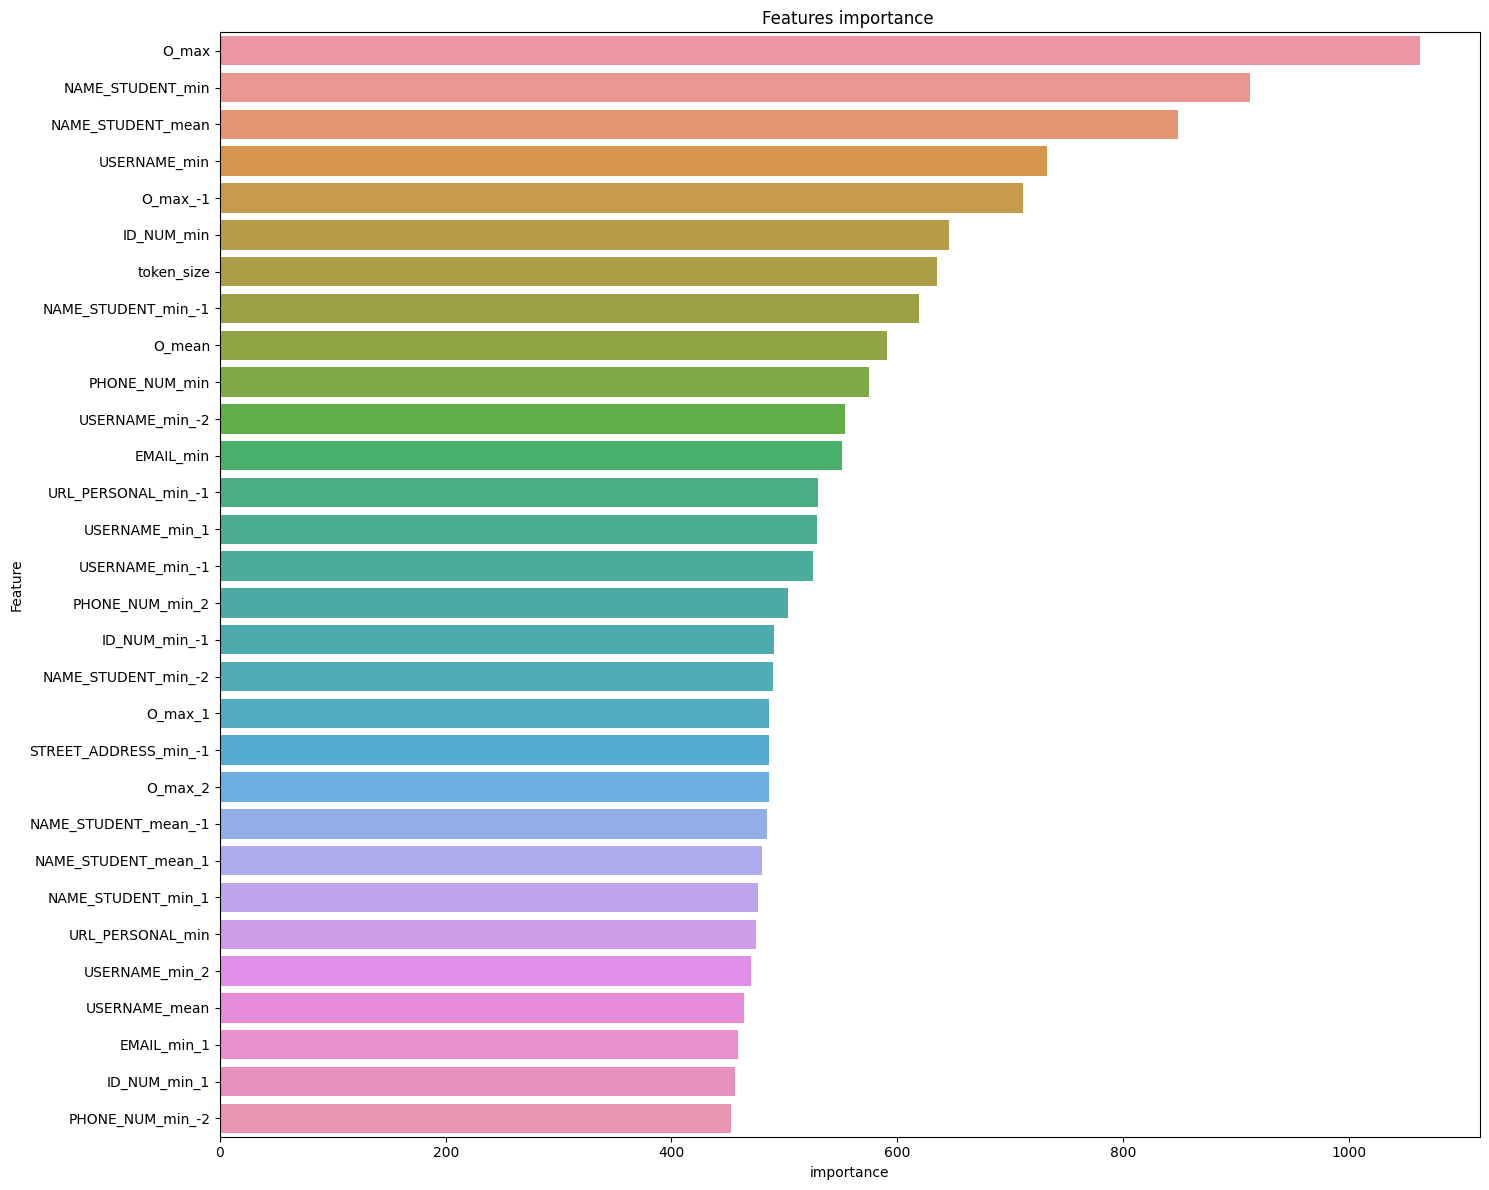

In [40]:
oof = kfold(args,df)

In [41]:
gt_df = df[df["fold_msk_5_seed_42"]==0].reset_index(drop=True)

In [42]:
gt_df = gt_df[gt_df.label!=7].reset_index(drop=True)

In [43]:
gt_df['labels'] = gt_df['label'].astype(str)+'-'+gt_df['I'].astype(int).astype(str)
gt_df["label_gt"] = gt_df["labels"].map(ID_TYPE).fillna(0).astype(int)
gt_df['label'] = gt_df['labels'].map(ID_NAME)
gt_df['row_id'] = np.arange(len(gt_df))

In [44]:
gt_df

,document,token,tokens,label_pred,score,NAME_STUDENT,EMAIL,USERNAME,ID_NUM,PHONE_NUM,URL_PERSONAL,STREET_ADDRESS,O,label,I,fold_msk_5_seed_42,NAME_STUDENT_dv3l,EMAIL_dv3l,USERNAME_dv3l,ID_NUM_dv3l,PHONE_NUM_dv3l,URL_PERSONAL_dv3l,STREET_ADDRESS_dv3l,O_dv3l,NAME_STUDENT_dv3l_rep05,EMAIL_dv3l_rep05,USERNAME_dv3l_rep05,ID_NUM_dv3l_rep05,PHONE_NUM_dv3l_rep05,URL_PERSONAL_dv3l_rep05,STREET_ADDRESS_dv3l_rep05,O_dv3l_rep05,NAME_STUDENT_mean,NAME_STUDENT_min,NAME_STUDENT_max,NAME_STUDENT_mean_1,NAME_STUDENT_min_1,NAME_STUDENT_max_1,NAME_STUDENT_mean_-1,NAME_STUDENT_min_-1,NAME_STUDENT_max_-1,NAME_STUDENT_mean_2,NAME_STUDENT_min_2,NAME_STUDENT_max_2,NAME_STUDENT_mean_-2,NAME_STUDENT_min_-2,NAME_STUDENT_max_-2,EMAIL_mean,EMAIL_min,EMAIL_max,EMAIL_mean_1,EMAIL_min_1,EMAIL_max_1,EMAIL_mean_-1,EMAIL_min_-1,EMAIL_max_-1,EMAIL_mean_2,EMAIL_min_2,EMAIL_max_2,EMAIL_mean_-2,EMAIL_min_-2,EMAIL_max_-2,USERNAME_mean,USERNAME_min,USERNAME_max,USERNAME_mean_1,USERNAME_min_1,USERNAME_max_1,USERNAME_mean_-1,USERNAME_min_-1,USERNAME_max_-1,USERNAME_mean_2,USERNAME_min_2,USERNAME_max_2,USERNAME_mean_-2,USERNAME_min_-2,USERNAME_max_-2,ID_NUM_mean,ID_NUM_min,ID_NUM_max,ID_NUM_mean_1,ID_NUM_min_1,ID_NUM_max_1,ID_NUM_mean_-1,ID_NUM_min_-1,ID_NUM_max_-1,ID_NUM_mean_2,ID_NUM_min_2,ID_NUM_max_2,ID_NUM_mean_-2,ID_NUM_min_-2,ID_NUM_max_-2,PHONE_NUM_mean,PHONE_NUM_min,PHONE_NUM_max,PHONE_NUM_mean_1,PHONE_NUM_min_1,PHONE_NUM_max_1,PHONE_NUM_mean_-1,PHONE_NUM_min_-1,PHONE_NUM_max_-1,PHONE_NUM_mean_2,PHONE_NUM_min_2,PHONE_NUM_max_2,PHONE_NUM_mean_-2,PHONE_NUM_min_-2,PHONE_NUM_max_-2,URL_PERSONAL_mean,URL_PERSONAL_min,URL_PERSONAL_max,URL_PERSONAL_mean_1,URL_PERSONAL_min_1,URL_PERSONAL_max_1,URL_PERSONAL_mean_-1,URL_PERSONAL_min_-1,URL_PERSONAL_max_-1,URL_PERSONAL_mean_2,URL_PERSONAL_min_2,URL_PERSONAL_max_2,URL_PERSONAL_mean_-2,URL_PERSONAL_min_-2,URL_PERSONAL_max_-2,STREET_ADDRESS_mean,STREET_ADDRESS_min,STREET_ADDRESS_max,STREET_ADDRESS_mean_1,STREET_ADDRESS_min_1,STREET_ADDRESS_max_1,STREET_ADDRESS_mean_-1,STREET_ADDRESS_min_-1,STREET_ADDRESS_max_-1,STREET_ADDRESS_mean_2,STREET_ADDRESS_min_2,STREET_ADDRESS_max_2,STREET_ADDRESS_mean_-2,STREET_ADDRESS_min_-2,STREET_ADDRESS_max_-2,O_mean,O_min,O_max,O_mean_1,O_min_1,O_max_1,O_mean_-1,O_min_-1,O_max_-1,O_mean_2,O_min_2,O_max_2,O_mean_-2,O_min_-2,O_max_-2,token_size,token_as_int,labels,label_gt,row_id
0,16,4,Gilberto,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,B-NAME_STUDENT,0.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.0001,0.0000,0.0001,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.9999,0.9997,1.0000,0.0001,0.0000,0.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8,0,0-0,0,0
1,16,5,Gamboa,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,I-NAME_STUDENT,1.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [45]:
pred = oof['clf'].predict(df[df["fold_msk_5_seed_42"]==0].reset_index(drop=True)[features],num_iteration=oof['clf'].best_iteration)

In [46]:
labels = pred.argmax(-1)
scores = pred.max(-1)

In [47]:
pred_df = df[df["fold_msk_5_seed_42"]==0][['document','token']]

In [48]:
pred_df['label'] = labels
pred_df['score'] = scores

In [49]:
pred_df = pred_df[(pred_df.label!=7) & ((pred_df.score>0.15))].reset_index(drop=True)
pred_df["I"] = ((pred_df.groupby('document')['label'].transform(lambda x:x.diff())==0) & (pred_df.groupby('document')['token'].transform(lambda x:x.diff())==1))*1
pred_df['labels'] = pred_df['label'].astype(str)+'-'+pred_df['I'].astype(str)
pred_df["label_pred"] = pred_df["labels"].map(ID_TYPE).fillna(0).astype(int)
pred_df['row_id'] = np.arange(len(pred_df))

In [50]:
pred_df['label'] = pred_df['labels'].map(ID_NAME)

In [51]:
df[df.document==16][features+['label','token']]

,NAME_STUDENT_mean,NAME_STUDENT_min,NAME_STUDENT_max,NAME_STUDENT_mean_1,NAME_STUDENT_min_1,NAME_STUDENT_max_1,NAME_STUDENT_mean_-1,NAME_STUDENT_min_-1,NAME_STUDENT_max_-1,NAME_STUDENT_mean_2,NAME_STUDENT_min_2,NAME_STUDENT_max_2,NAME_STUDENT_mean_-2,NAME_STUDENT_min_-2,NAME_STUDENT_max_-2,EMAIL_mean,EMAIL_min,EMAIL_max,EMAIL_mean_1,EMAIL_min_1,EMAIL_max_1,EMAIL_mean_-1,EMAIL_min_-1,EMAIL_max_-1,EMAIL_mean_2,EMAIL_min_2,EMAIL_max_2,EMAIL_mean_-2,EMAIL_min_-2,EMAIL_max_-2,USERNAME_mean,USERNAME_min,USERNAME_max,USERNAME_mean_1,USERNAME_min_1,USERNAME_max_1,USERNAME_mean_-1,USERNAME_min_-1,USERNAME_max_-1,USERNAME_mean_2,USERNAME_min_2,USERNAME_max_2,USERNAME_mean_-2,USERNAME_min_-2,USERNAME_max_-2,ID_NUM_mean,ID_NUM_min,ID_NUM_max,ID_NUM_mean_1,ID_NUM_min_1,ID_NUM_max_1,ID_NUM_mean_-1,ID_NUM_min_-1,ID_NUM_max_-1,ID_NUM_mean_2,ID_NUM_min_2,ID_NUM_max_2,ID_NUM_mean_-2,ID_NUM_min_-2,ID_NUM_max_-2,PHONE_NUM_mean,PHONE_NUM_min,PHONE_NUM_max,PHONE_NUM_mean_1,PHONE_NUM_min_1,PHONE_NUM_max_1,PHONE_NUM_mean_-1,PHONE_NUM_min_-1,PHONE_NUM_max_-1,PHONE_NUM_mean_2,PHONE_NUM_min_2,PHONE_NUM_max_2,PHONE_NUM_mean_-2,PHONE_NUM_min_-2,PHONE_NUM_max_-2,URL_PERSONAL_mean,URL_PERSONAL_min,URL_PERSONAL_max,URL_PERSONAL_mean_1,URL_PERSONAL_min_1,URL_PERSONAL_max_1,URL_PERSONAL_mean_-1,URL_PERSONAL_min_-1,URL_PERSONAL_max_-1,URL_PERSONAL_mean_2,URL_PERSONAL_min_2,URL_PERSONAL_max_2,URL_PERSONAL_mean_-2,URL_PERSONAL_min_-2,URL_PERSONAL_max_-2,STREET_ADDRESS_mean,STREET_ADDRESS_min,STREET_ADDRESS_max,STREET_ADDRESS_mean_1,STREET_ADDRESS_min_1,STREET_ADDRESS_max_1,STREET_ADDRESS_mean_-1,STREET_ADDRESS_min_-1,STREET_ADDRESS_max_-1,STREET_ADDRESS_mean_2,STREET_ADDRESS_min_2,STREET_ADDRESS_max_2,STREET_ADDRESS_mean_-2,STREET_ADDRESS_min_-2,STREET_ADDRESS_max_-2,O_mean,O_min,O_max,O_mean_1,O_min_1,O_max_1,O_mean_-1,O_min_-1,O_max_-1,O_mean_2,O_min_2,O_max_2,O_mean_-2,O_min_-2,O_max_-2,token_as_int,token_size,label_pred,label,token
0,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,1.0000,0.9999,1.0000,NaN,NaN,NaN,1.0000,1.0000,1.0000,NaN,NaN,NaN,1.0000,1.0000,1.0000,0,9,7,7,0
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.9999,1.0000,1.0000,1.0000,1.0000,NaN,NaN,NaN,0.9999,0.9997,1.0000,0,7,7,7,1
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0

In [52]:
pred_df[pred_df.document==16]

,document,token,label,score,I,labels,label_pred,row_id


In [53]:
gt_df[gt_df.document==16]

,document,token,tokens,label_pred,score,NAME_STUDENT,EMAIL,USERNAME,ID_NUM,PHONE_NUM,URL_PERSONAL,STREET_ADDRESS,O,label,I,fold_msk_5_seed_42,NAME_STUDENT_dv3l,EMAIL_dv3l,USERNAME_dv3l,ID_NUM_dv3l,PHONE_NUM_dv3l,URL_PERSONAL_dv3l,STREET_ADDRESS_dv3l,O_dv3l,NAME_STUDENT_dv3l_rep05,EMAIL_dv3l_rep05,USERNAME_dv3l_rep05,ID_NUM_dv3l_rep05,PHONE_NUM_dv3l_rep05,URL_PERSONAL_dv3l_rep05,STREET_ADDRESS_dv3l_rep05,O_dv3l_rep05,NAME_STUDENT_mean,NAME_STUDENT_min,NAME_STUDENT_max,NAME_STUDENT_mean_1,NAME_STUDENT_min_1,NAME_STUDENT_max_1,NAME_STUDENT_mean_-1,NAME_STUDENT_min_-1,NAME_STUDENT_max_-1,NAME_STUDENT_mean_2,NAME_STUDENT_min_2,NAME_STUDENT_max_2,NAME_STUDENT_mean_-2,NAME_STUDENT_min_-2,NAME_STUDENT_max_-2,EMAIL_mean,EMAIL_min,EMAIL_max,EMAIL_mean_1,EMAIL_min_1,EMAIL_max_1,EMAIL_mean_-1,EMAIL_min_-1,EMAIL_max_-1,EMAIL_mean_2,EMAIL_min_2,EMAIL_max_2,EMAIL_mean_-2,EMAIL_min_-2,EMAIL_max_-2,USERNAME_mean,USERNAME_min,USERNAME_max,USERNAME_mean_1,USERNAME_min_1,USERNAME_max_1,USERNAME_mean_-1,USERNAME_min_-1,USERNAME_max_-1,USERNAME_mean_2,USERNAME_min_2,USERNAME_max_2,USERNAME_mean_-2,USERNAME_min_-2,USERNAME_max_-2,ID_NUM_mean,ID_NUM_min,ID_NUM_max,ID_NUM_mean_1,ID_NUM_min_1,ID_NUM_max_1,ID_NUM_mean_-1,ID_NUM_min_-1,ID_NUM_max_-1,ID_NUM_mean_2,ID_NUM_min_2,ID_NUM_max_2,ID_NUM_mean_-2,ID_NUM_min_-2,ID_NUM_max_-2,PHONE_NUM_mean,PHONE_NUM_min,PHONE_NUM_max,PHONE_NUM_mean_1,PHONE_NUM_min_1,PHONE_NUM_max_1,PHONE_NUM_mean_-1,PHONE_NUM_min_-1,PHONE_NUM_max_-1,PHONE_NUM_mean_2,PHONE_NUM_min_2,PHONE_NUM_max_2,PHONE_NUM_mean_-2,PHONE_NUM_min_-2,PHONE_NUM_max_-2,URL_PERSONAL_mean,URL_PERSONAL_min,URL_PERSONAL_max,URL_PERSONAL_mean_1,URL_PERSONAL_min_1,URL_PERSONAL_max_1,URL_PERSONAL_mean_-1,URL_PERSONAL_min_-1,URL_PERSONAL_max_-1,URL_PERSONAL_mean_2,URL_PERSONAL_min_2,URL_PERSONAL_max_2,URL_PERSONAL_mean_-2,URL_PERSONAL_min_-2,URL_PERSONAL_max_-2,STREET_ADDRESS_mean,STREET_ADDRESS_min,STREET_ADDRESS_max,STREET_ADDRESS_mean_1,STREET_ADDRESS_min_1,STREET_ADDRESS_max_1,STREET_ADDRESS_mean_-1,STREET_ADDRESS_min_-1,STREET_ADDRESS_max_-1,STREET_ADDRESS_mean_2,STREET_ADDRESS_min_2,STREET_ADDRESS_max_2,STREET_ADDRESS_mean_-2,STREET_ADDRESS_min_-2,STREET_ADDRESS_max_-2,O_mean,O_min,O_max,O_mean_1,O_min_1,O_max_1,O_mean_-1,O_min_-1,O_max_-1,O_mean_2,O_min_2,O_max_2,O_mean_-2,O_min_-2,O_max_-2,token_size,token_as_int,labels,label_gt,row_id
0,16,4,Gilberto,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,B-NAME_STUDENT,0.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.0001,0.0000,0.0001,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.9999,0.9997,1.0000,0.0001,0.0000,0.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8,0,0-0,0,0
1,16,5,Gamboa,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,I-NAME_STUDENT,1.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

In [54]:
compute_metrics(pred_df, gt_df)

{'f5_prec': 0.7375328083989501,
 'f5_rec': 0.5203703703703704,
 'f5_micro': 0.5263309559829984,
 'ents_per_type': {'NAME_STUDENT': 0.558642972536349,
  'URL_PERSONAL': 0.6037151702786377,
  'ID_NUM': 0.0,
  'STREET_ADDRESS': 0.0,
  'EMAIL': 0.0,
  'PHONE_NUM': 0.0,
  'USERNAME': 0.0}}

In [54]:
gt_df

,document,token,tokens,label_pred,score,NAME_STUDENT,EMAIL,USERNAME,ID_NUM,PHONE_NUM,URL_PERSONAL,STREET_ADDRESS,O,label,I,fold_msk_5_seed_42,NAME_STUDENT_dv3l,EMAIL_dv3l,USERNAME_dv3l,ID_NUM_dv3l,PHONE_NUM_dv3l,URL_PERSONAL_dv3l,STREET_ADDRESS_dv3l,O_dv3l,NAME_STUDENT_dv3l_rep05,EMAIL_dv3l_rep05,USERNAME_dv3l_rep05,ID_NUM_dv3l_rep05,PHONE_NUM_dv3l_rep05,URL_PERSONAL_dv3l_rep05,STREET_ADDRESS_dv3l_rep05,O_dv3l_rep05,NAME_STUDENT_mean,NAME_STUDENT_min,NAME_STUDENT_max,NAME_STUDENT_mean_1,NAME_STUDENT_min_1,NAME_STUDENT_max_1,NAME_STUDENT_mean_-1,NAME_STUDENT_min_-1,NAME_STUDENT_max_-1,NAME_STUDENT_mean_2,NAME_STUDENT_min_2,NAME_STUDENT_max_2,NAME_STUDENT_mean_-2,NAME_STUDENT_min_-2,NAME_STUDENT_max_-2,EMAIL_mean,EMAIL_min,EMAIL_max,EMAIL_mean_1,EMAIL_min_1,EMAIL_max_1,EMAIL_mean_-1,EMAIL_min_-1,EMAIL_max_-1,EMAIL_mean_2,EMAIL_min_2,EMAIL_max_2,EMAIL_mean_-2,EMAIL_min_-2,EMAIL_max_-2,USERNAME_mean,USERNAME_min,USERNAME_max,USERNAME_mean_1,USERNAME_min_1,USERNAME_max_1,USERNAME_mean_-1,USERNAME_min_-1,USERNAME_max_-1,USERNAME_mean_2,USERNAME_min_2,USERNAME_max_2,USERNAME_mean_-2,USERNAME_min_-2,USERNAME_max_-2,ID_NUM_mean,ID_NUM_min,ID_NUM_max,ID_NUM_mean_1,ID_NUM_min_1,ID_NUM_max_1,ID_NUM_mean_-1,ID_NUM_min_-1,ID_NUM_max_-1,ID_NUM_mean_2,ID_NUM_min_2,ID_NUM_max_2,ID_NUM_mean_-2,ID_NUM_min_-2,ID_NUM_max_-2,PHONE_NUM_mean,PHONE_NUM_min,PHONE_NUM_max,PHONE_NUM_mean_1,PHONE_NUM_min_1,PHONE_NUM_max_1,PHONE_NUM_mean_-1,PHONE_NUM_min_-1,PHONE_NUM_max_-1,PHONE_NUM_mean_2,PHONE_NUM_min_2,PHONE_NUM_max_2,PHONE_NUM_mean_-2,PHONE_NUM_min_-2,PHONE_NUM_max_-2,URL_PERSONAL_mean,URL_PERSONAL_min,URL_PERSONAL_max,URL_PERSONAL_mean_1,URL_PERSONAL_min_1,URL_PERSONAL_max_1,URL_PERSONAL_mean_-1,URL_PERSONAL_min_-1,URL_PERSONAL_max_-1,URL_PERSONAL_mean_2,URL_PERSONAL_min_2,URL_PERSONAL_max_2,URL_PERSONAL_mean_-2,URL_PERSONAL_min_-2,URL_PERSONAL_max_-2,STREET_ADDRESS_mean,STREET_ADDRESS_min,STREET_ADDRESS_max,STREET_ADDRESS_mean_1,STREET_ADDRESS_min_1,STREET_ADDRESS_max_1,STREET_ADDRESS_mean_-1,STREET_ADDRESS_min_-1,STREET_ADDRESS_max_-1,STREET_ADDRESS_mean_2,STREET_ADDRESS_min_2,STREET_ADDRESS_max_2,STREET_ADDRESS_mean_-2,STREET_ADDRESS_min_-2,STREET_ADDRESS_max_-2,O_mean,O_min,O_max,O_mean_1,O_min_1,O_max_1,O_mean_-1,O_min_-1,O_max_-1,O_mean_2,O_min_2,O_max_2,O_mean_-2,O_min_-2,O_max_-2,token_size,token_as_int,labels,label_gt,row_id
0,16,4,Gilberto,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,B-NAME_STUDENT,0.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.0001,0.0000,0.0001,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.9999,0.9997,1.0000,0.0001,0.0000,0.0001,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8,0,0-0,0,0
1,16,5,Gamboa,0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,I-NAME_STUDENT,1.0000,0,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.9999,1.0000,0.9999,0.9999,1.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,